In [6]:
import tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio.v3 as iio

In [7]:
# define the folders of ground truth, segmentation and output(if needed)
GT_folder = 'D:/Ding/UChicago/cellsegmentation/data/tissuenet_v1.1/tiff/C0_selected_GT'
pred_folder = 'D:/Ding/UChicago/cellsegmentation/data/tissuenet_v1.1/tiff/C0C1_selected_cellpose_tissuenet'
output_folder = 'D:/Ding/UChicago/cellsegmentation/data/tissuenet_v1.1/tiff/C0C1_selected_cellpose_tissuenet_iou'

if not os.path.isdir(output_folder):   
    os.makedirs(output_folder)

In [8]:
method_name = 'cellpose'
ch_name = 'cyto'
threshold_t = 0.6

In [9]:
# import function
from iou_per_object import iou_per_object

filenames = [x for x in os.listdir(GT_folder) if os.path.isfile(os.path.join(GT_folder, x)) and ('.tif' in x)]
all_seg2GT_iou_per_object = []
all_GT2seg_iou_per_object = []
all_precision_per_image = []
all_recall_per_image = []

for filenameID in range(len(filenames)):

    filename = filenames[filenameID]
    # read in the GT and segmentation
    GT_labels = tifffile.imread(os.path.join(GT_folder, filename))
    new_filename =  filename.replace("seg_C0", "img_C0C1")
    seg_labels = iio.imread(os.path.join(pred_folder, new_filename[:-5]+'_cp_masks_tissuenet.png'))                           
   
    # calculate IOUs of all objects in segmentation wrt GT
    iou_array = iou_per_object(seg_labels, GT_labels)
    iou_array = iou_array[iou_array>=0]
    # calculate precision in this image
    this_image_precision = iou_array[iou_array>threshold_t].shape[0]/iou_array.shape[0]
    # append to the results of the set
    all_seg2GT_iou_per_object = np.append(all_seg2GT_iou_per_object, iou_array,axis=0)    
    all_precision_per_image = np.append(all_precision_per_image, this_image_precision)

    # awap GT and segmentation to get the recall
    GT_seg_iou_array = iou_per_object(GT_labels, seg_labels)
    GT_seg_iou_array = GT_seg_iou_array[GT_seg_iou_array>=0]
    all_GT2seg_iou_per_object = np.append(all_GT2seg_iou_per_object, GT_seg_iou_array,axis=0)    
    this_image_recall = GT_seg_iou_array[GT_seg_iou_array>threshold_t].shape[0]/GT_seg_iou_array.shape[0]
    # calculate recall in this image
    all_recall_per_image = np.append(all_recall_per_image, this_image_recall)


# remove the invalid ones
all_seg2GT_iou_per_object = all_seg2GT_iou_per_object[all_seg2GT_iou_per_object>=0]
all_GT2seg_iou_per_object = all_GT2seg_iou_per_object[all_GT2seg_iou_per_object>=0]

c:\Users\dingl\anaconda3\envs\segmentation\lib\site-packages\imageio\plugins\pillow.py:301: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  UserWarning,


Displaying evaluation results

Text(0, 55.440000000000005, 'Per object recall=0.82')

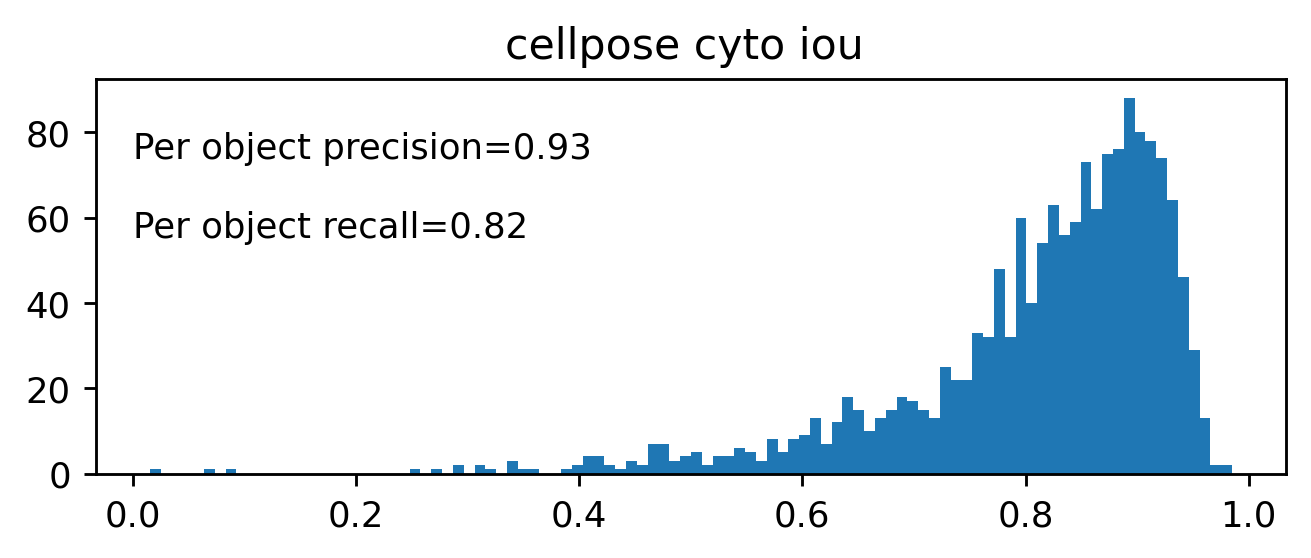

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,2), dpi=256, facecolor='w', edgecolor='k')

# calculate precision and recall based on all objects in all the images
per_object_precision = all_seg2GT_iou_per_object[all_seg2GT_iou_per_object>threshold_t].shape[0]/all_seg2GT_iou_per_object.shape[0]
per_object_recall = all_GT2seg_iou_per_object[all_GT2seg_iou_per_object>threshold_t].shape[0]/all_GT2seg_iou_per_object.shape[0]

plt.hist(all_seg2GT_iou_per_object,100)
plt.title(method_name + ' '+ ch_name +' iou ')
ylim = ax.get_ylim()
plt.text(0,ylim[-1]*0.8,'Per object precision='+ "%.2f" % per_object_precision)
plt.text(0,ylim[-1]*0.6,'Per object recall='+ "%.2f" % per_object_recall)

Text(0, 2.52, ' Average precision=0.94')

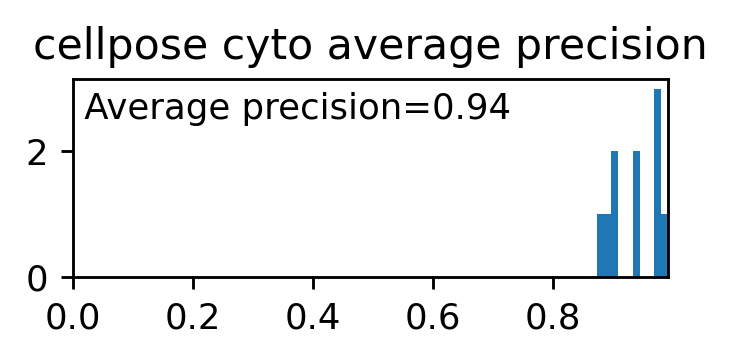

In [11]:
fig, ax = plt.subplots(1,1, figsize=(3,1), dpi=256, facecolor='w', edgecolor='k')
# calculate the average precision of per image results
average_image_precision = all_precision_per_image.mean()
plt.hist(all_precision_per_image)
plt.title(method_name + ' '+ ch_name +' average precision')
ylim = ax.get_ylim()
ax.set_xlim(0,all_precision_per_image.max())
plt.text(0,ylim[-1]*0.8,' Average precision='+ "%.2f" % average_image_precision)


Text(0, 2.52, ' Average precision=0.83')

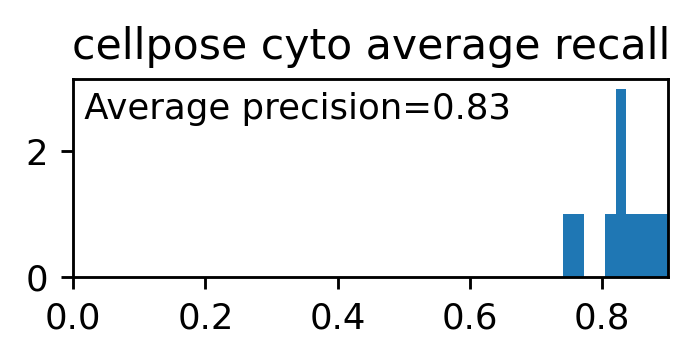

In [12]:
fig, ax = plt.subplots(1,1, figsize=(3,1), dpi=256, facecolor='w', edgecolor='k')
# calculate the average recall of per image results
average_image_recall = all_recall_per_image.mean()
plt.hist(all_recall_per_image)
plt.title(method_name + ' '+ ch_name +' average recall')
ax.set_xlim(0,all_recall_per_image.max())
ylim = ax.get_ylim()
plt.text(0,ylim[-1]*0.8,' Average precision='+ "%.2f" % average_image_recall)
